In [433]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.feature import canny
from collections import defaultdict
from IPython.display import clear_output

In [434]:
#suradnice hladaneho kratera
TARGET_Y = 3735
TARGET_X = 15600

# nastavenie snimky mesiaca
SHIFT = 2000
START_LINE = 3000; END_LINE = 30_000 #Y
START_SAMPLE = 10_000; END_SAMPLE = 25_000 #X

# Toleranica
POS_ERR_TOL = 100 # Tolerancia chyby polohy
SIMILARITY_TOL = 5 # Tolerancia voci duplikatom

# nastavenie Houghovej transformacie
NUM_OF_THETAS = 200
PRECISION_FOR_MAIN_CRATER = 0.3 # Presnost detekcie velkeho kratera
PRECISION_FOR_CHILD_CRATER = 0.4 # Presnost detekdie malych kraterov
MAIN_RADIUS = 380 # Velkost velkeho kratera
CHILD_RADIUS = [25,5] # Velkost maleho kratera




Text(0.5, 0, 'Image width')

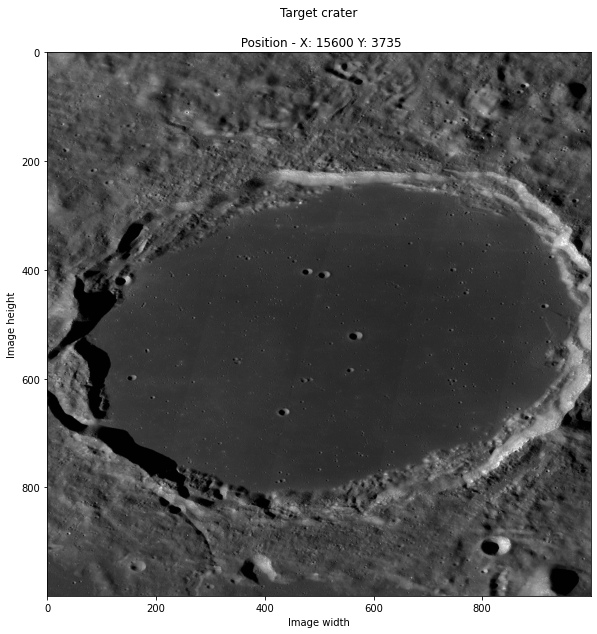

In [435]:
# nacitanie obrazku v plnej velkosti
moon = io.imread('WAC_GL000.tif')

# oznacenie velkeho kratera
moon[TARGET_Y][TARGET_X] = 0

# odchylky cielovej oblasti
TARGET_AREA = moon[TARGET_Y-500: TARGET_Y+500, TARGET_X-500: TARGET_X+500]
plt.figure(figsize=(10,10))
plt.imshow(TARGET_AREA, cmap='gray')
plt.title("Target crater\n\n Position - X: {} Y: {}".format(TARGET_X, TARGET_Y))
plt.ylabel("Image height")
plt.xlabel("Image width")


In [436]:
#funkcia prehladavajuca obrazok a snaziaca sa najst odchylku
def find_target(area, search_for=0): #area - vstupny obrazok, search_for - hodnota udajoveho typu - 0
    for x in range(area.shape[0]):
        for y in range(area.shape[1]):
            if area[x][y] == search_for:
                return True #ak som nasiel

    return False #ak nie

In [437]:
# kreslenie kruhu
def draw_circle(image, circle_parameters, title, fill=False):
    # image - vstupný obrazok
    # circle_parameters - kruh (stredové body x a y, priemer)
    # title - retazec nazvu pozemku
    # fill - boolean pre vyplnenie kruhu
    fig, ax = plt.subplots()
    fig.set_size_inches(25,25)
    ax.imshow(image, cmap='gray')
    ax.add_artist(plt.Circle((circle_parameters[1], circle_parameters[0]),circle_parameters[2], fill=fill, color="blue"))
    plt.title(title)
    plt.show()


In [438]:
# predbezne spracovanie obrazu pred detekciou okrajov
def preprocessing(image, kernel_1_size, kernel_2_size):
    # obrázok -  vstupný obrazok
    # kernel_2_size - n-tica s velkostou morfologického jadra
    # kernel_1_size - n-tica s velkostou morfologického jadra

    kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_1_size))
    kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_2_size))

    morph = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_1)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel_1)

    gradient_image = cv2.morphologyEx(morph, cv2.MORPH_GRADIENT, kernel_2)
    _, final = cv2.threshold(gradient_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    
    return final #predspracovanie konecneho obrazku

In [439]:
# Houghova transformacia na vyhladavanie kruhov
def find_circle(edges, radius, no_thetas, precision):
    # edges - okraje obrazu
    # radius - polomer kruhov
    # no_thetas - počet thetas
    # precision - tolerancie každého kruhu
    thetas = []
    for t in range(no_thetas):
        theta = 2 * np.pi * t / no_thetas
        thetas.append((int(radius * np.cos(theta)), int(radius * np.sin(theta)), radius))

    accumulator = defaultdict(int)
    # vytvaranie Houghovych kruhov pre okrajove pixeli
    for x in range(edges.shape[0]):
        for y in range(edges.shape[1]):
            if edges[x][y]:
                for i in range(len(thetas)):
                    a = x - thetas[i][0] #x
                    b = y - thetas[i][1] #y
                    accumulator[(a, b, thetas[i][2])] += 1

    # Zaznam uspesnych kruhov
    best_circles = []
    for possible_circle, vote in sorted(accumulator.items(), key=lambda i: -i[1]):
        if vote / no_thetas >= precision and all((possible_circle[0] - x_0) ** 2 + (possible_circle[1] - y_0) ** 2 > r ** 2 for x_0, y_0, r in best_circles):
            best_circles.append(possible_circle)
                
    return best_circles



In [440]:
# Detekcia velkeho kratera

it_counter = 1
for y in range(START_LINE, END_LINE, SHIFT):
    for x in range(START_SAMPLE, END_SAMPLE, SHIFT):            
        clear_output(wait=True)
        print("Iteration: {} - Searching for a target crater".format(it_counter))
        working_area = moon[y:y+SHIFT, x:x+SHIFT]
        target = find_target(working_area, 0)
        if target:
            print("Target crater found")
            working_area_edge = canny(working_area)
            circles = find_circle(working_area_edge, MAIN_RADIUS, NUM_OF_THETAS, PRECISION_FOR_MAIN_CRATER)
            for circle in circles:
                position_error = np.abs(TARGET_Y - (y+circle[1]) + TARGET_X - (x+circle[0]))
                print("Detected circle with poistion error: {} pixels".format(position_error))
                if position_error <= POS_ERR_TOL:
                    detect_crater = circle
                    title = "Detected crater in position - Y: {} X: {} with position error: {}px".format(detect_crater[1]+x, detect_crater[0]+y, position_error)
                    draw_circle(working_area, detect_crater, title)
                    break
            break
        it_counter += 1
    if target:
        break

Iteration: 3 - Searching for a target crater
Target crater found


In [441]:
# Detekcia maleho kratera vo velkom kratery

def find_small_craters(area, crater, radius_range, num_of_craters=5, plot=True, y_offset=150, x_offset=110):
    # area - 2d pole predstavujúce okraje obrazu
    # crater - male kratery vo velkom
    # radius_range - n-tica s minimálnym a maximálnym polomerom
    # num_of_craters - počet vykresľovacích kráterov
    # plot - zobrazenie kraterov
    # y_offset, x_offset - počet pixelov, ktoré sa majú zmenšiť pri priblížení

    zoomed_area = moon[TARGET_Y - crater[2]+y_offset : TARGET_Y + crater[2]-y_offset,
                       TARGET_X - crater[2]+x_offset : TARGET_X + crater[2]-x_offset]

    preparation = preprocessing(zoomed_area, (3,3), (3,3))
    edges = canny(preparation, 7)

    if plot:
        plt.figure(figsize=(20,20))
        plt.subplot(221)
        plt.imshow(zoomed_area)
        plt.title("Najdeny krater")
        plt.ylabel("vyska obrazku")
        plt.xlabel("sirka obrazku")
        plt.subplot(221)
        plt.imshow(edges)
        plt.title("Canny detekcia")
        plt.ylabel("vyska obrazku")
        plt.xlabel("sirka obraky")
        plt.show()


    print("Male kratery najdene\n")
    small_craters = []
    for r in range(max(radius_range), min(radius_range), -2):

        circles = find_circle(edges, r, NUM_OF_THETAS, PRECISION_FOR_CHILD_CRATER)
        for circle in circles:
            small_craters.append(circle)

    # zbavenie sa duplikatnych kraterov
    cleaned_small_craters = []
    for i in range(len(small_craters)-1, 0, -1):
        similiar = False
        for j in range(i-2, 0,-2):
            similarity = (small_craters[j][0] - small_craters[i][0]) + (small_craters[j][1] - small_craters[i][1])
            if np.abs(similarity) <= SIMILARITY_TOL:
                similiar = True
                break

        if not similiar:
            cleaned_small_craters.append(small_craters[i]);

    print("Najdene kratery: {}\n".format(len(cleaned_small_craters)))

    if plot:
        fig, ax = plt.subplots()
        plt.title("Najdenie malych kraterov")
        plt.ylabel("vyska obrazku")
        plt.xlabel("sirka obrazku")

        for real_crater, small_crater in enumerate(cleaned_small_craters):
            if real_crater > num_of_craters-1:
                break
            fig.set_size_inches(10,10)
            ax.imshow(zoomed_area, cmap='gray')
            ax.add_artist(plt.Circle((small_crater[1],small_crater[0]),small_crater[2], fill=False, color="green"))
        plt.show()

    return cleaned_small_craters


<ipython-input-441-c8e16adfed27>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(221)


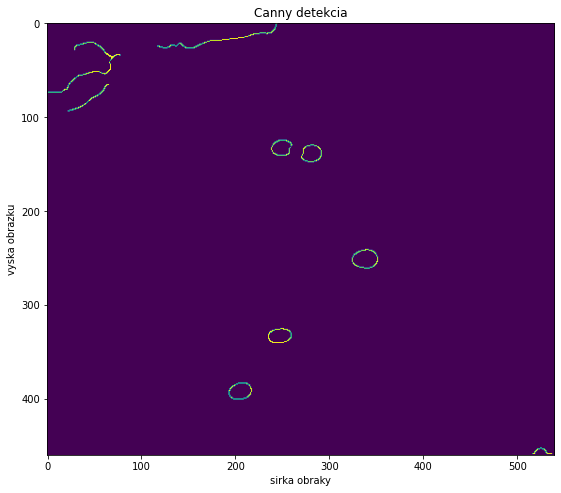

Male kratery najdene

Najdene kratery: 5



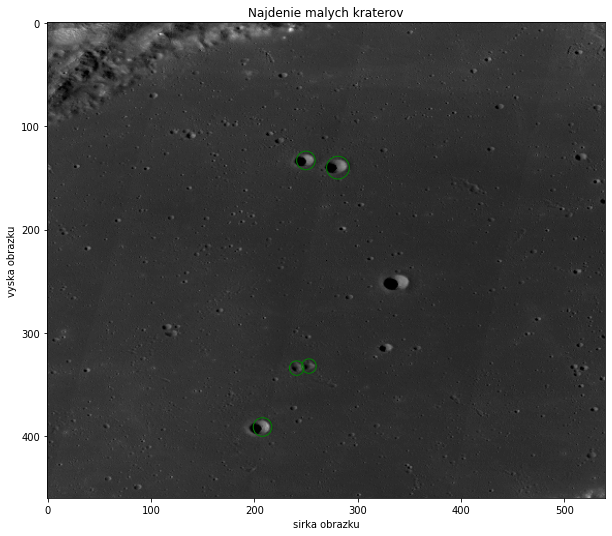

In [442]:
small_craters = find_small_craters(working_area, detect_crater, CHILD_RADIUS)

############################################################
#            Velky krater: Y: 4611 X: 14734 R: 380        #
#---------------------------------------------------------#
#                   Male kratery: 	5	          #
#---------------------------------------------------------#
#  Pozicie malych kraterov:    	 Y: 3768 X: 15712	  #
###########################################################
#  Pozicie malych kraterov:    	 Y: 3756 X: 15714	  #
###########################################################
#  Pozicie malych kraterov:    	 Y: 3723 X: 15771	  #
###########################################################
#  Pozicie malych kraterov:    	 Y: 3765 X: 15513	  #
###########################################################
#  Pozicie malych kraterov:    	 Y: 3796 X: 15520	  #
###########################################################


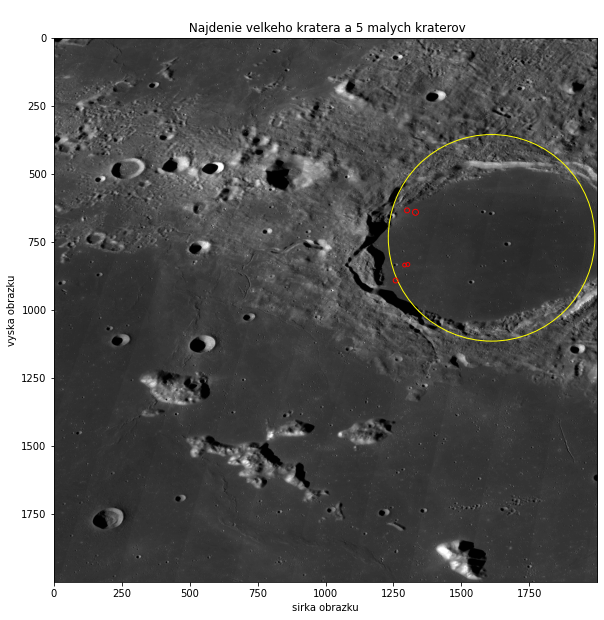

In [443]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
plt.title("\n Najdenie velkeho kratera a {} malych kraterov".format(len(small_craters)))
plt.ylabel("vyska obrazku")
plt.xlabel("sirka obrazku")

ax.imshow(working_area, cmap='gray')
fig.set_size_inches(10,10)
ax.add_artist(plt.Circle((detect_crater[1], detect_crater[0]), detect_crater[2], fill=False, color="yellow"))

print('############################################################')
print("#            Velky krater: Y: {} X: {} R: {}        #".format(detect_crater[1]+y, detect_crater[0]+x, detect_crater[2]))
print('#---------------------------------------------------------#')
print('#                   Male kratery: \t{}\t          #'.format(len(small_craters)))
print('#---------------------------------------------------------#')


for crater_i, crater in enumerate(small_craters):

    
    real_y = (crater[1]+TARGET_Y+detect_crater[2] - 600)
    real_x = (crater[0]+TARGET_X+detect_crater[2] - 600)
    print("#  Pozicie malych kraterov:    \t Y: {} X: {}\t  #".format(real_y, real_x))
    print('###########################################################')
    fig.set_size_inches(10,10)
    ax.add_artist(plt.Circle((crater[1]+1050, crater[0]+500), crater[2], fill=False, color="red"))
